
# Detection Taxonomy Simulations — DAG + Taxonomy (Staged vs Nash Equilibrium)

This notebook reproduces and **illustrates the theorems and simulation results** using the two provided modules:

- `PerformanceGraphsClass.py`
- `TaxonomyNodeClass.py`

It follows the **DAG and taxonomy setup** used in `__main__` of `PerformanceGraphsClass.py`:
1. Build the taxonomy (tree)
2. Build the signed, **directed acyclic graph** (DAG) of conditional detections
3. Register the DAG onto the taxonomy nodes
4. Validate DAG acyclicity + compute a topological ordering
5. Compare **staged (single sweep, parents frozen)** vs **Nash equilibrium (coordinate ascent)** performance

We then illustrate the theorems via simulations:
- **Continuity** of precision for conditioned detections
- **Monotonicity** (enabling ↑, suppressing ↓)
- **Recall monotonicity**
- **Ancestor (taxonomy parent) conditioning improves precision**
- Global performance differences under **equilibrium vs staged** (including across replications)

> **Note**: All figures are generated with `matplotlib` only (no seaborn).

In [7]:

# --- Imports
import os, sys, math, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure our modules can be imported
sys.path.insert(0, "/mnt/data")

import importlib.util
def load_module_from_path(name, path):
    spec = importlib.util.spec_from_file_location(name, str(path))
    mod = importlib.util.module_from_spec(spec)
    sys.modules[name] = mod
    spec.loader.exec_module(mod)
    return mod

PG = load_module_from_path("PerformanceGraphsClass", "./"+"PerformanceGraphsClass.py")
TN = load_module_from_path("TaxonomyNodeClass", "./"+"/TaxonomyNodeClass.py")

PG, TN


(<module 'PerformanceGraphsClass' from '/Users/ryanwarnick/Documents/Performance_Graphs_Paper/Performance_Graphs/./PerformanceGraphsClass.py'>,
 <module 'TaxonomyNodeClass' from '/Users/ryanwarnick/Documents/Performance_Graphs_Paper/Performance_Graphs/.//TaxonomyNodeClass.py'>)

In [8]:

def build_net(seed=0, a=0.4, b=0.6, gamma=0.9, pos_w=0.30, neg_w=0.30):
    random.seed(seed); np.random.seed(seed)
    root = PG.build_demo_taxonomy()
    dag = PG.build_demo_dag()
    # Register DAG onto nodes (as in __main__)
    PG.register_dag_on_nodes(root, dag)
    net = PG.TaxonomyBayesianNetwork(root, dag, a=a, b=b, gamma=gamma)
    # Optionally strengthen positive/negative DAG weights at the node level
    for n in net.nodes():
        n.pos_weight = pos_w
        n.neg_weight = neg_w
    # Validate DAG is acyclic and get a toposort
    _ = net._validate_and_toposort()
    return net, root, dag

def effective_rows(net):
    """Compute per-node precision/recall using the network's effective (DAG-conditioned) s/t maps."""
    s_map, t_map = net.neighbor_st()
    rows = []
    for n in net.nodes():
        p = n.precision(n.lam, s_map, t_map)
        r = n.recall(n.lam, s_map, t_map)
        rows.append((n.name, float(n.lam), float(p), float(r)))
    return pd.DataFrame(rows, columns=["Node","lambda","Precision","Recall"]).sort_values("Node").reset_index(drop=True)

def staged_vs_equilibrium_once(seed=0, gamma=0.9, pos_w=0.30, neg_w=0.30, a=0.4, b=0.6):
    # Staged (single topological sweep, parents frozen)
    net_s, *_ = build_net(seed=seed, gamma=gamma, pos_w=pos_w, neg_w=neg_w, a=a, b=b)
    net_s.staged_local_optimization_dag()
    df_staged = effective_rows(net_s)
    # Equilibrium (coordinate ascent on thresholds)
    net_e, *_ = build_net(seed=seed, gamma=gamma, pos_w=pos_w, neg_w=neg_w, a=a, b=b)
    net_e.coordinate_ascent(max_iter=180)
    df_equil = effective_rows(net_e)
    return df_staged, df_equil

def taxonomy_edges(root):
    edges = []
    def walk(n):
        for c in n.children:
            edges.append((n.name, c.name))
            walk(c)
    walk(root)
    return edges


## Taxonomy + DAG overlay

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/notebook_taxonomy_dag.png'

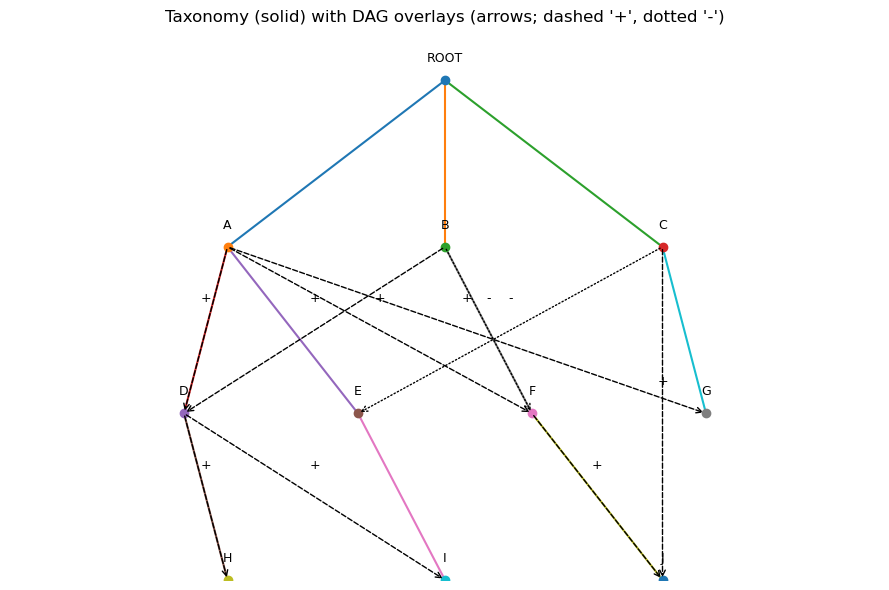

In [9]:

# Build once and draw
_, root_demo, dag_demo = build_net(seed=1)
img_path = "/mnt/data/notebook_taxonomy_dag.png"
PG.draw_taxonomy_and_dag(root_demo, dag_demo, img_path)
from IPython.display import Image, display
display(Image(img_path))


## Staged vs Equilibrium — single run

,Node,lambda,Precision,Recall
0,A,0.0225,0.332665,0.988686
1,B,0.0225,0.332665,0.988686
2,C,0.0225,0.332665,0.988686
3,D,0.2875,0.426702,1.000000
4,E,0.0300,0.331886,0.828506
5,F,0.0225,0.332665,0.988686
6,G,0.2875,0.426702,1.000000
7,H,0.2075,0.429728,1.000000
8,I,0.2075,0.429728,1.000000
9,J,0.2875,0.426702,1.000000


,Node,lambda,Precision,Recall
0,A,0.0975,0.371856,0.950000
1,B,0.0075,0.318543,0.996243
2,C,0.0075,0.318543,0.996243
3,D,0.2800,0.430446,0.999927
4,E,0.0325,0.339594,0.824818
5,F,0.0950,0.393134,0.936517
6,G,0.2675,0.441134,0.999862
7,H,0.2100,0.432130,1.000000
8,I,0.2100,0.432130,1.000000
9,J,0.2800,0.434683,0.997770


Means — staged: {'Precision': 0.3758882653735748, 'Recall': 0.9792669313243949}
Means — equil: {'Precision': 0.3858961104947738, 'Recall': 0.9718241775622501}


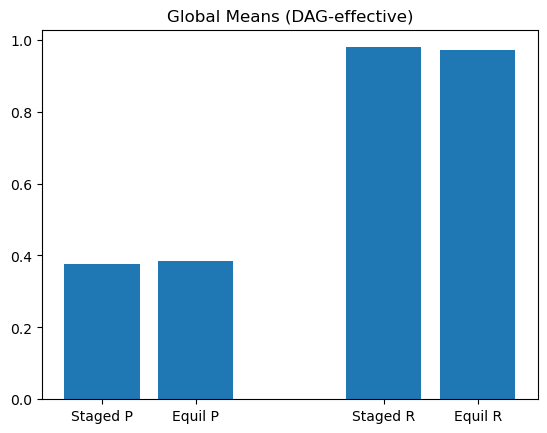

In [10]:

df_staged, df_equil = staged_vs_equilibrium_once(seed=3, gamma=0.95, pos_w=0.32, neg_w=0.32)
display(df_staged)
display(df_equil)

# Global means
m_staged = df_staged[["Precision","Recall"]].mean()
m_equil  = df_equil[["Precision","Recall"]].mean()
print("Means — staged:", m_staged.to_dict())
print("Means — equil:",  m_equil.to_dict())

# Plot global means
plt.figure()
plt.bar([0,1,3,4], [m_staged["Precision"], m_equil["Precision"], m_staged["Recall"], m_equil["Recall"]],
        tick_label=["Staged P","Equil P","Staged R","Equil R"])
plt.title("Global Means (DAG-effective)")
plt.show()


## Replications: repeat the Nash equilibrium result

Precision — staged: {'mean': 0.3758882653735747, 'median': 0.3758882653735748, 'p05': 0.3758882653735748, 'p95': 0.3758882653735748}
Precision — equil: {'mean': 0.38601206591890963, 'median': 0.3858961104947738, 'p05': 0.38401481880991833, 'p95': 0.3883220041789369}
Recall    — staged: {'mean': 0.9792669313243949, 'median': 0.9792669313243949, 'p05': 0.9792669313243949, 'p95': 0.9792669313243949}
Recall    — equil: {'mean': 0.9718271878261445, 'median': 0.9718454744102395, 'p05': 0.9695161709326067, 'p95': 0.9737902232592415}


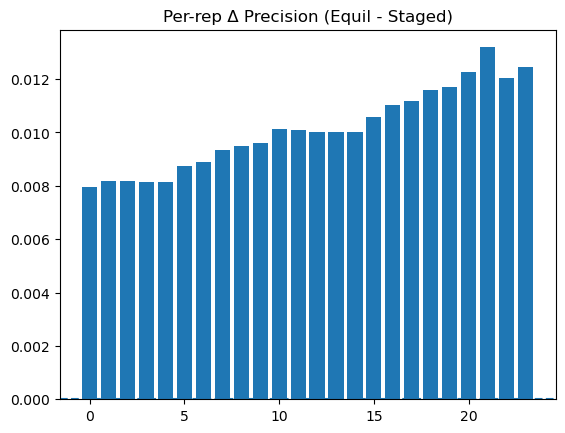

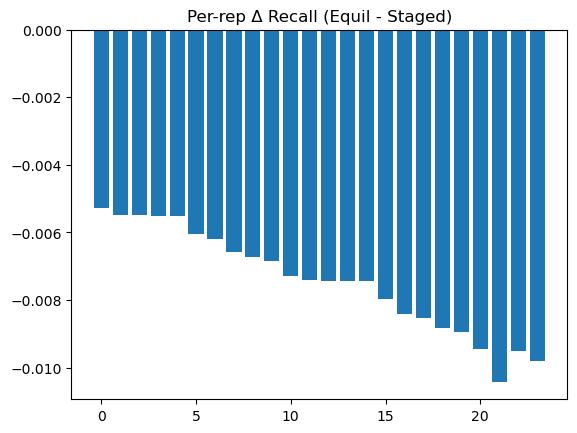

In [11]:

def replicate(n_reps=20, base_seed=10):
    means_staged = []
    means_equil  = []
    # Vary gamma mildly over reps to reflect different downstream-value regimes
    for i in range(n_reps):
        seed = base_seed + i
        gamma = 0.5 + 0.1*i  # monotone ramp; could also sample
        df_s, df_e = staged_vs_equilibrium_once(seed=seed, gamma=gamma, pos_w=0.32, neg_w=0.32)
        means_staged.append(df_s[["Precision","Recall"]].mean().values)
        means_equil.append(df_e[["Precision","Recall"]].mean().values)
    means_staged = np.array(means_staged)
    means_equil  = np.array(means_equil)
    return means_staged, means_equil

ms, me = replicate(n_reps=24, base_seed=50)
msP, msR = ms[:,0], ms[:,1]
meP, meR = me[:,0], me[:,1]

# Summaries
def summary(x): 
    return dict(mean=float(np.mean(x)), median=float(np.median(x)), p05=float(np.percentile(x,5)), p95=float(np.percentile(x,95)))

print("Precision — staged:", summary(msP))
print("Precision — equil:",  summary(meP))
print("Recall    — staged:", summary(msR))
print("Recall    — equil:",  summary(meR))

# Visualize distribution of deltas (equil - staged)
dP = meP - msP
dR = meR - msR

plt.figure()
plt.bar(np.arange(len(dP)), dP)
plt.axhline(0, linestyle='--')
plt.title("Per-rep Δ Precision (Equil - Staged)")
plt.show()

plt.figure()
plt.bar(np.arange(len(dR)), dR)
plt.axhline(0, linestyle='--')
plt.title("Per-rep Δ Recall (Equil - Staged)")
plt.show()


## Theorem illustrations — DAG conditioning

In [ ]:

# Continuity: Precision(H | D) over (λ_D, λ_H)
net_t, *_ = build_net(seed=7, gamma=0.95, pos_w=0.32, neg_w=0.32)
net_t.staged_local_optimization_dag()

ls = np.linspace(0.02, 0.98, 60)
Z = np.zeros((len(ls), len(ls)))
for i, lamD in enumerate(ls):
    net_t.name_to_node()["D"].lam = float(lamD)
    for j, lamH in enumerate(ls):
        net_t.name_to_node()["H"].lam = float(lamH)
        s_map, t_map = net_t.neighbor_st()
        H = net_t.name_to_node()["H"]
        Z[i,j] = H.precision(H.lam, s_map, t_map)

plt.figure()
plt.imshow(Z, origin='lower', extent=[ls.min(), ls.max(), ls.min(), ls.max()], aspect='auto')
plt.xlabel("λ_H"); plt.ylabel("λ_D"); plt.title("Continuity: Precision(H|D)")
plt.colorbar(label="Precision(H)")
plt.show()

# Monotonicity (+): enabling D→H
xs = np.linspace(0.02, 0.98, 100)
ys = []
lamH = float(net_t.name_to_node()["H"].lam)
for lamD in xs:
    net_t.name_to_node()["D"].lam = float(lamD)
    net_t.name_to_node()["H"].lam = lamH
    s_map, t_map = net_t.neighbor_st()
    H = net_t.name_to_node()["H"]
    ys.append(H.precision(H.lam, s_map, t_map))

plt.figure()
plt.plot(xs, ys)
plt.xlabel("λ_D"); plt.ylabel("Precision(H)"); plt.title("Monotonicity (+): D→H")
plt.show()

# Monotonicity (−): suppressing C→E
ys2 = []
lamE = float(net_t.name_to_node()["E"].lam)
for lamC in xs:
    net_t.name_to_node()["C"].lam = float(lamC)
    net_t.name_to_node()["E"].lam = lamE
    s_map, t_map = net_t.neighbor_st()
    E = net_t.name_to_node()["E"]
    ys2.append(E.precision(E.lam, s_map, t_map))

plt.figure()
plt.plot(xs, ys2)
plt.xlabel("λ_C"); plt.ylabel("Precision(E)"); plt.title("Monotonicity (−): C→E")
plt.show()


In [ ]:

# Recall monotonicity (+): D→H
xs = np.linspace(0.02, 0.98, 100)
yr = []
lamH = float(net_t.name_to_node()["H"].lam)
for lamD in xs:
    net_t.name_to_node()["D"].lam = float(lamD)
    net_t.name_to_node()["H"].lam = lamH
    s_map, t_map = net_t.neighbor_st()
    H = net_t.name_to_node()["H"]
    yr.append(H.recall(H.lam, s_map, t_map))

plt.figure()
plt.plot(xs, yr)
plt.xlabel("λ_D"); plt.ylabel("Recall(H)"); plt.title("Recall Monotonicity (+): D→H")
plt.show()


## Taxonomy conditioning (parent → child), then DAG effects

In [ ]:

# Implement taxonomy-first conditioning: child inherits a centered shift from its taxonomy parent
def neighbor_st_tax_then_dag(net, tax_weight=0.35):
    base_s = {n.name: n.base_sensitivity(n.lam) for n in net.nodes()}
    base_t = {n.name: n.base_specificity(n.lam) for n in net.nodes()}
    # taxonomy pass
    inter_s = dict(base_s); inter_t = dict(base_t)
    for n in net.nodes():
        if n.parent is None: continue
        p = n.parent
        inter_s[n.name] = float(max(0.0, min(1.0, inter_s[n.name] + tax_weight*(base_s[p.name] - 0.5))))
        inter_t[n.name] = float(max(0.0, min(1.0, inter_t[n.name] + tax_weight*(base_t[p.name] - 0.5))))
    # DAG pass
    final_s, final_t = {}, {}
    for n in net.nodes():
        s, t = n.effective_s_and_t(n.lam, inter_s, inter_t)
        final_s[n.name] = float(s); final_t[n.name] = float(t)
    return final_s, final_t

# Example edge from taxonomy
_, rootX, _ = build_net(seed=5)
edge = taxonomy_edges(rootX)[-1] if taxonomy_edges(rootX) else ("ROOT","A")
parent_name, child_name = edge
parent_name, child_name


In [ ]:

# Continuity under taxonomy conditioning
net_tax, *_ = build_net(seed=6, gamma=1.1, pos_w=0.32, neg_w=0.32)
net_tax.staged_local_optimization_dag()

ls = np.linspace(0.02, 0.98, 60)
Z = np.zeros((len(ls), len(ls)))
for i, lp in enumerate(ls):
    net_tax.name_to_node()[parent_name].lam = float(lp)
    for j, lc in enumerate(ls):
        net_tax.name_to_node()[child_name].lam = float(lc)
        s_map, t_map = neighbor_st_tax_then_dag(net_tax, tax_weight=0.40)
        C = net_tax.name_to_node()[child_name]
        Z[i,j] = C.precision(C.lam, s_map, t_map)

plt.figure()
plt.imshow(Z, origin='lower', extent=[ls.min(), ls.max(), ls.min(), ls.max()], aspect='auto')
plt.xlabel(f"λ_{child_name}"); plt.ylabel(f"λ_{parent_name}")
plt.title(f"Continuity (taxonomy): Precision({child_name}|{parent_name})")
plt.colorbar(label="Precision")
plt.show()

# Monotonicity (taxonomy)
xs = np.linspace(0.02, 0.98, 100)
ys = []
lam_child = float(net_tax.name_to_node()[child_name].lam)
for lp in xs:
    net_tax.name_to_node()[parent_name].lam = float(lp)
    net_tax.name_to_node()[child_name].lam = lam_child
    s_map, t_map = neighbor_st_tax_then_dag(net_tax, tax_weight=0.40)
    C = net_tax.name_to_node()[child_name]
    ys.append(C.precision(C.lam, s_map, t_map))

plt.figure()
plt.plot(xs, ys)
plt.xlabel(f"λ_{parent_name}"); plt.ylabel(f"Precision({child_name})")
plt.title(f"Monotonicity (taxonomy): {parent_name} → {child_name}")
plt.show()


## DAG tweak: condition ROOT on A (A → ROOT)

In [ ]:

# Baseline (no A→ROOT), staged for stable λs
net0, root0, dag0 = build_net(seed=42, gamma=1.2, pos_w=0.32, neg_w=0.32)
net0.staged_local_optimization_dag()
lams0 = {n.name: float(n.lam) for n in net0.nodes()}

# Measure ROOT without A→ROOT
s0, t0 = net0.neighbor_st()
R0 = net0.name_to_node()["ROOT"]
p0 = R0.precision(R0.lam, s0, t0); r0 = R0.recall(R0.lam, s0, t0)

# Add A→ROOT and re-evaluate at same λs
dag1 = {k: dict(v) for k,v in dag0.items()}
dag1.setdefault("ROOT", {}); dag1["ROOT"]["A"] = +1

net1, root1, _ = build_net(seed=42, gamma=1.2, pos_w=0.32, neg_w=0.32)
PG.register_dag_on_nodes(root1, dag1)
net1.dag_parents = dag1
_ = net1._validate_and_toposort()
for n in net1.nodes():
    if n.name in lams0: n.lam = lams0[n.name]

s1, t1 = net1.neighbor_st()
R1 = net1.name_to_node()["ROOT"]
p1 = R1.precision(R1.lam, s1, t1); r1 = R1.recall(R1.lam, s1, t1)

# Table + bar plot
df_root = pd.DataFrame([
    {"Case":"Unconditioned (no A→ROOT)", "Precision":p0, "Recall":r0},
    {"Case":"Conditioned (A→ROOT)",    "Precision":p1, "Recall":r1},
])
display(df_root)

plt.figure()
plt.bar([0,1], [p0, p1], tick_label=["Unconditioned","Conditioned (A→ROOT)"])
plt.ylabel("ROOT Precision"); plt.title("Effect of DAG conditioning ROOT on A (same λs)")
plt.show()

# Curves vs λ_A with conditioning active
netC, rootC, _ = build_net(seed=42, gamma=1.2, pos_w=0.32, neg_w=0.32)
PG.register_dag_on_nodes(rootC, dag1)
netC.dag_parents = dag1
for n in netC.nodes():
    if n.name in lams0: n.lam = lams0[n.name]

xs = np.linspace(0.02, 0.98, 80)
prec_curve, rec_curve = [], []
for la in xs:
    netC.name_to_node()["A"].lam = float(la)
    sC, tC = netC.neighbor_st()
    RR = netC.name_to_node()["ROOT"]
    prec_curve.append(RR.precision(RR.lam, sC, tC))
    rec_curve.append(RR.recall(RR.lam, sC, tC))

plt.figure()
plt.plot(xs, prec_curve); plt.xlabel("λ_A"); plt.ylabel("ROOT Precision"); plt.title("ROOT Precision vs λ_A (A→ROOT)")
plt.show()

plt.figure()
plt.plot(xs, rec_curve); plt.xlabel("λ_A"); plt.ylabel("ROOT Recall"); plt.title("ROOT Recall vs λ_A (A→ROOT)")
plt.show()
